In [ ]:
# ================================
# IMPORT LIBRARIES AND SETUP
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import pickle
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.metrics import classification_report, confusion_matrix,cohen_kappa_score, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.layers import (LSTM, RepeatVector, TimeDistributed, Input, Dense, Dropout, SpatialDropout1D, GlobalAveragePooling1D,
                                     BatchNormalization, LayerNormalization, Add,
                                     Bidirectional, MultiHeadAttention)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras import layers, models
from keras_tuner.tuners import RandomSearch

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create directories for artifacts and visualizations
artifacts_dir = "artifacts"
visualization_dir = "visualization"
checkpoint_dir = 'checkpoints'

os.makedirs(artifacts_dir, exist_ok=True)
os.makedirs(visualization_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Artifacts will be saved in: {artifacts_dir}")
print(f"Visualizations will be saved in: {visualization_dir}")
print(f"Checkpoints will be saved in: {checkpoint_dir}")

All libraries imported successfully!
TensorFlow version: 2.18.0
Artifacts will be saved in: artifacts
Visualizations will be saved in: visualization
Checkpoints will be saved in: checkpoints


In [2]:
with open(os.path.join(artifacts_dir, 'data_train_preprocessing.pkl'), 'rb') as f:
    X_train, y_train = pickle.load(f)

In [3]:
print(X_train.shape)
print(y_train.shape)

print(X_train[:10])
print(y_train[:10])

(30354, 9)
(30354, 8)
   hour    minute  day_of_week  is_weekend  door_state_encoded  door_roll_std  \
0  0.45  0.711864          1.0         1.0                 0.0            0.0   
1  0.45  0.711864          1.0         1.0                 0.0            0.0   
2  0.45  0.711864          1.0         1.0                 0.0            0.0   
3  0.45  0.711864          1.0         1.0                 0.0            0.0   
4  0.45  0.711864          1.0         1.0                 0.0            0.0   
5  0.45  0.711864          1.0         1.0                 0.0            0.0   
6  0.45  0.711864          1.0         1.0                 0.0            0.0   
7  0.45  0.711864          1.0         1.0                 0.0            0.0   
8  0.45  0.711864          1.0         1.0                 0.0            0.0   
9  0.45  0.711864          1.0         1.0                 0.0            0.0   

   phone_roll_mean  phone_dom_freq  phone_entropy  
0              0.0             0.0

In [4]:
with open(os.path.join(artifacts_dir, 'data_val_preprocessing.pkl'), 'rb') as f:
    X_val, y_val = pickle.load(f)

In [5]:
print(X_val.shape)
print(y_val.shape)

print(X_val[:10])
print(y_val[:10])

(4246, 9)
(4246, 8)
   hour    minute  day_of_week  is_weekend  door_state_encoded  door_roll_std  \
0  0.45  0.694915          1.0         1.0                 0.0            0.0   
1  0.45  0.694915          1.0         1.0                 0.0            0.0   
2  0.45  0.694915          1.0         1.0                 0.0            0.0   
3  0.45  0.694915          1.0         1.0                 0.0            0.0   
4  0.45  0.694915          1.0         1.0                 0.0            0.0   
5  0.45  0.694915          1.0         1.0                 0.0            0.0   
6  0.45  0.694915          1.0         1.0                 0.0            0.0   
7  0.45  0.694915          1.0         1.0                 0.0            0.0   
8  0.45  0.694915          1.0         1.0                 0.0            0.0   
9  0.45  0.694915          1.0         1.0                 0.0            0.0   

   phone_roll_mean  phone_dom_freq  phone_entropy  
0              0.0           -0.25  

In [6]:
with open(os.path.join(artifacts_dir, 'data_test_preprocessing.pkl'), 'rb') as f:
    X_test, y_test = pickle.load(f)

In [7]:
print(X_test.shape)
print(y_test.shape)

print(X_test[:10])
print(y_test[:10])

(4987, 9)
(4987, 8)
   hour    minute  day_of_week  is_weekend  door_state_encoded  door_roll_std  \
0  0.85  0.949153          0.0         0.0                 0.0            0.8   
1  0.85  0.949153          0.0         0.0                 0.0            0.8   
2  0.85  0.949153          0.0         0.0                 0.0            0.6   
3  0.85  0.949153          0.0         0.0                 0.0            0.6   
4  0.85  0.949153          0.0         0.0                 0.0            0.6   
5  0.85  0.949153          0.0         0.0                 0.0            0.6   
6  0.85  0.949153          0.0         0.0                 0.0            0.0   
7  0.85  0.949153          0.0         0.0                 0.0            0.0   
8  0.85  0.949153          0.0         0.0                 0.0            0.0   
9  0.85  0.949153          0.0         0.0                 1.0            0.6   

   phone_roll_mean  phone_dom_freq  phone_entropy  
0              0.4            1.00  

In [8]:
class_names = ['backdoor', 'ddos', 'injection', 'normal', 'password', 'ransomware', 'scanning', 'xss']

# Konversi one-hot ke label string
y_train_labels = np.array(class_names)[np.argmax(y_train, axis=1)]
y_val_labels = np.array(class_names)[np.argmax(y_test, axis=1)]

# Filter hanya data normal
X_train_ae = X_train[y_train_labels == 'normal'].copy()
X_val_ae = X_test[y_val_labels == 'normal'].copy()
X_test_ae = X_val.copy()

y_train_ae = y_train[y_train_labels == 'normal']
y_val_ae = y_test[y_val_labels == 'normal']
y_test_ae = y_val.copy()

In [9]:
print("Data AE - Train:", X_train_ae.shape)
print("Data AE - Val  :", X_val_ae.shape)
print("Data AE - Test  :", X_test_ae.shape)

print(y_train_ae.shape)
print(y_val_ae.shape)
print(y_test_ae.shape)
print(y_train_ae[:10])
print(y_val_ae[:10])
print(y_test_ae[:10])

Data AE - Train: (11129, 9)
Data AE - Val  : (2230, 9)
Data AE - Test  : (4246, 9)
(11129, 8)
(2230, 8)
(4246, 8)
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]


In [10]:
# === Print statistik dataset ===
print(f"\nDataset shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:  {X_val.shape}, y_val:  {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

print('Class train distribution:')
class_labels_train = np.argmax(y_train, axis=1)
# Hitung distribusi kelas
class_distribution_train = pd.Series(class_labels_train).value_counts().sort_index()
print(class_distribution_train)

print('\nClass val distribution:')
class_labels_val = np.argmax(y_val, axis=1)
# Hitung distribusi kelas
class_distribution_val = pd.Series(class_labels_val).value_counts().sort_index()
print(class_distribution_val)

print('\nClass test distribution:')
class_labels_test = np.argmax(y_test, axis=1)
# Hitung distribusi kelas
class_distribution_test = pd.Series(class_labels_test).value_counts().sort_index()
print(class_distribution_test)


Dataset shapes:
X_train: (30354, 9), y_train: (30354, 8)
X_val:  (4246, 9), y_val:  (4246, 8)
X_test:  (4987, 9), y_test:  (4987, 8)
Class train distribution:
0     3923
1     4016
2     3753
3    11129
4     3991
5     2127
6      438
7      977
Name: count, dtype: int64

Class val distribution:
0     516
1     508
2     567
3    1641
4     513
5     330
6      46
7     125
Name: count, dtype: int64

Class test distribution:
0     561
1     476
2     680
3    2230
4     496
5     445
6      45
7      54
Name: count, dtype: int64


In [11]:
# ================================
# PREPARE DATA FOR LSTM
# ================================

print("\n" + "="*50)
print("PREPARING DATA FOR MODEL")
print("="*50)

def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps + 1):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps - 1])  # Target adalah titik akhir dari window
    return np.array(X_seq), np.array(y_seq)

# Set sequence length
time_steps = 10

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

X_train_ae_seq, y_train_ae_seq = create_sequences(X_train_ae, y_train_ae, time_steps)
X_val_ae_seq, y_val_ae_seq = create_sequences(X_val_ae, y_val_ae, time_steps)
X_test_ae_seq, y_test_ae_seq = create_sequences(X_test_ae, y_test_ae, time_steps)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Training label sequences shape: {y_train_seq.shape}")
print(f"\nValidation sequences shape: {X_val_seq.shape}")
print(f"Validation label sequences shape: {y_val_seq.shape}")
print(f"\nTest sequences shape: {X_test_seq.shape}")
print(f"Test label sequences shape: {y_test_seq.shape}")

print(f"\nTraining sequences ae shape: {X_train_ae_seq.shape}")
print(f"Training label sequences ae shape: {y_train_ae_seq.shape}")
print(f"\nValidation sequences ae shape: {X_val_ae_seq.shape}")
print(f"Validation label sequences ae shape: {y_val_ae_seq.shape}")
print(f"\nTest sequences ae shape: {X_test_ae_seq.shape}")
print(f"Test label sequences ae shape: {y_test_ae_seq.shape}")


PREPARING DATA FOR MODEL
Training sequences shape: (30345, 10, 9)
Training label sequences shape: (30345, 8)

Validation sequences shape: (4237, 10, 9)
Validation label sequences shape: (4237, 8)

Test sequences shape: (4978, 10, 9)
Test label sequences shape: (4978, 8)

Training sequences ae shape: (11120, 10, 9)
Training label sequences ae shape: (11120, 8)

Validation sequences ae shape: (2221, 10, 9)
Validation label sequences ae shape: (2221, 8)

Test sequences ae shape: (4237, 10, 9)
Test label sequences ae shape: (4237, 8)


In [12]:
print(X_train_seq.shape[2])
print(X_train_seq.shape[1])
print(X_train_seq.shape[0])
print(y_train_seq.shape[1])

9
10
30345
8


In [18]:
# Hyperparameter search
sequence_length = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]
n_classes = y_train_seq.shape[1]

def build_model(hp):
    inputs = Input(shape=(sequence_length, n_features))
    inputs = SpatialDropout1D(hp.Float('spatial_dropout', 0.0, 0.3, step=0.1))(inputs)

    # LSTM Layer 1
    bi1 = Bidirectional(LSTM(
        hp.Int('lstm_units_1', 32, 256, step=32),
        return_sequences=True,
        dropout=hp.Float('lstm_dropout_1', 0.1, 0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout_1', 0.1, 0.4, step=0.1)
    ))(inputs)

    # LSTM Layer 2
    if hp.Boolean("use_second_lstm"):
        bi2 = Bidirectional(LSTM(
            hp.Int('lstm_units_2', 16, 128, step=16),
            return_sequences=True,
            dropout=hp.Float('lstm_dropout_2', 0.1, 0.5, step=0.1),
            recurrent_dropout=hp.Float('recurrent_dropout_2', 0.1, 0.4, step=0.1)
        ))(bi1)
        lstm_out = bi2
    else:
        lstm_out = bi1
    lstm_out = LayerNormalization()(lstm_out)

    # Multi-head Attention
    attn = MultiHeadAttention(
        num_heads=hp.Choice('attention_heads', [2, 4, 8]),
        key_dim=hp.Choice('attention_dim', [32, 64, 128]),
        dropout=hp.Float('attention_dropout', 0.1, 0.5, step=0.1)
    )(lstm_out, lstm_out)

    attn = Add()([lstm_out, attn])
    attn = LayerNormalization()(attn)
    attn = Dropout(hp.Float('post_attention_dropout', 0.1, 0.5, step=0.1))(attn)

    pooled = GlobalAveragePooling1D()(attn)

    # Dense layer 1
    dense = Dense(hp.Int('dense_units_1', 64, 256, step=64), activation='relu')(pooled)
    dense = BatchNormalization()(dense)
    dense = Dropout(hp.Float('dense_dropout_1', 0.2, 0.5, step=0.1))(dense)

    # Dense layer 2
    dense = Dense(hp.Int('dense_units_2', 32, 128, step=32), activation='relu')(dense)
    dense = Dropout(hp.Float('dense_dropout_2', 0.2, 0.5, step=0.1))(dense)

    outputs = Dense(n_classes, activation='softmax')(dense)

    model = Model(inputs=inputs, outputs=outputs, name='classifier_tuned')

    optimizer = Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5]))
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
    )
    return model

In [19]:
class MultiMetricRandomSearch(RandomSearch):
    def score_trial(self, trial):
        acc = trial.metrics.get_last_value("val_accuracy")
        loss = trial.metrics.get_last_value("val_loss")
        auc = trial.metrics.get_last_value("val_auc")
        precision = trial.metrics.get_last_value("val_precision")
        recall = trial.metrics.get_last_value("val_recall")

        if None in [acc, loss, auc, precision, recall]:
            return float('-inf')

        # Ubah loss ke bentuk metrik (semakin kecil, semakin baik → dibalik)
        norm_loss = 1 / (1 + loss)

        # Gabungkan metrik dengan bobot yang kamu tentukan
        score = (
            0.25 * acc +
            0.20 * norm_loss +
            0.20 * auc +
            0.20 * precision +
            0.15 * recall
        )

        return score

In [21]:
# Callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,               
    restore_best_weights=True 
)

checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stop, checkpoint, reduce_lr]

In [22]:
# class_weight
# Calculate class weights for imbalanced data
y_train_labels = np.argmax(y_train_seq, axis=1)
raw_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
# Gunakan log transform agar tidak ekstrem
scaled_weights = np.log1p(raw_weights)
# Normalisasi supaya rata-rata = 1
normalized_weights = scaled_weights / np.mean(scaled_weights)
# Konversi ke dict
class_weight_dict = dict(enumerate(normalized_weights))
print("Final class weights:", class_weight_dict)

Final class weights: {0: 0.6868639984127919, 1: 0.6752387471015954, 2: 0.7092258972295978, 3: 0.2980123287265249, 4: 0.6783235301946763, 5: 1.0393954718343004, 6: 2.302901220360685, 7: 1.6100388061398283}


In [26]:
tuner = MultiMetricRandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=15,
    executions_per_trial=1,
    directory="multi_metric_tuning",
    project_name="multimetric_eval"
)

tuner.search(X_train_seq, y_train_seq,
             validation_data=(X_val_seq, y_val_seq),
             epochs=15,
             batch_size=32,
             class_weight=class_weight_dict,
             callbacks=[early_stop],
             verbose=1
             )

Trial 15 Complete [00h 06m 54s]
val_accuracy: 0.7458106875419617

Best val_accuracy So Far: 0.9915034174919128
Total elapsed time: 02h 52m 23s


In [27]:
tuner.results_summary()

Results summary
Results in multi_metric_tuning\multimetric_eval
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
spatial_dropout: 0.2
lstm_units_1: 128
lstm_dropout_1: 0.1
recurrent_dropout_1: 0.4
use_second_lstm: True
attention_heads: 2
attention_dim: 32
attention_dropout: 0.2
post_attention_dropout: 0.1
dense_units_1: 256
dense_dropout_1: 0.4
dense_units_2: 96
dense_dropout_2: 0.2
learning_rate: 0.001
lstm_units_2: 80
lstm_dropout_2: 0.5
recurrent_dropout_2: 0.30000000000000004
Score: 0.9915034174919128

Trial 12 summary
Hyperparameters:
spatial_dropout: 0.2
lstm_units_1: 32
lstm_dropout_1: 0.1
recurrent_dropout_1: 0.4
use_second_lstm: True
attention_heads: 4
attention_dim: 64
attention_dropout: 0.1
post_attention_dropout: 0.1
dense_units_1: 256
dense_dropout_1: 0.2
dense_units_2: 64
dense_dropout_2: 0.4
learning_rate: 0.0001
lstm_units_2: 64
lstm_dropout_2: 0.4
recurrent_dropout_2: 0.1
Score: 0.9863110780715942

Trial 01 summa

In [28]:
best_model_classifier = tuner.get_best_models(num_models=1)[0]
best_model_classifier.summary()

Model: "classifier_tuned"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_1CLONE │ (None, 10, 9)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 10, 256)   │    141,312 │ keras_tensor_1CL… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 10, 160)   │    215,680 │ bidirectional[1]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 160)   │        320 │ bidirectional_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 160)   │     41,312 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 160)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 160)   │        320 │ add[1][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 160)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 160)       │          0 │ dropout_1[1][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     41,216 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[1][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 96)        │     24,672 │ dropout_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 96)        │          0 │ dense_1[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │        776 │ dropout_3[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 466,632 (1.78 MB)

 Trainable params: 466,120 (1.78 MB)

 Non-trainable params: 512 (2.00 KB)

In [29]:
# Ambil trial terbaik
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

# Ambil semua metrik dari trial tersebut
metrics = best_trial.metrics

print("===== Hasil Trial Terbaik (Berdasarkan Gabungan Metrik) =====")
print(f"val_accuracy : {metrics.get_last_value('val_accuracy')}")
print(f"val_loss     : {metrics.get_last_value('val_loss')}")
print(f"val_auc      : {metrics.get_last_value('val_auc')}")
print(f"val_precision: {metrics.get_last_value('val_precision')}")
print(f"val_recall   : {metrics.get_last_value('val_recall')}")
print("\n===== Hyperparameter terbaik =====")
print(best_trial.hyperparameters.values)

===== Hasil Trial Terbaik (Berdasarkan Gabungan Metrik) =====
val_accuracy : 0.9915034174919128
val_loss     : 0.06359996646642685
val_auc      : 0.9970797896385193
val_precision: 0.991706132888794
val_recall   : 0.987727165222168

===== Hyperparameter terbaik =====
{'spatial_dropout': 0.2, 'lstm_units_1': 128, 'lstm_dropout_1': 0.1, 'recurrent_dropout_1': 0.4, 'use_second_lstm': True, 'attention_heads': 2, 'attention_dim': 32, 'attention_dropout': 0.2, 'post_attention_dropout': 0.1, 'dense_units_1': 256, 'dense_dropout_1': 0.4, 'dense_units_2': 96, 'dense_dropout_2': 0.2, 'learning_rate': 0.001, 'lstm_units_2': 80, 'lstm_dropout_2': 0.5, 'recurrent_dropout_2': 0.30000000000000004}


In [30]:
y_pred = best_model_classifier.predict(X_test_seq)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_seq, axis=1)

print(classification_report(y_true_labels, y_pred_labels))

156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       561
           1       0.98      0.99      0.99       476
           2       0.99      0.99      0.99       680
           3       1.00      0.98      0.99      2221
           4       1.00      0.99      0.99       496
           5       0.99      0.99      0.99       445
           6       0.51      0.93      0.66        45
           7       0.90      0.96      0.93        54

    accuracy                           0.99      4978
   macro avg       0.92      0.98      0.94      4978
weighted avg       0.99      0.99      0.99      4978



In [31]:
# Balanced Accuracy & Kappa Score
print("Balanced Accuracy:", balanced_accuracy_score(y_true_labels, y_pred_labels))
print("Cohen's Kappa Score:", cohen_kappa_score(y_true_labels, y_pred_labels))

Balanced Accuracy: 0.9783425453199462
Cohen's Kappa Score: 0.9803314790457784


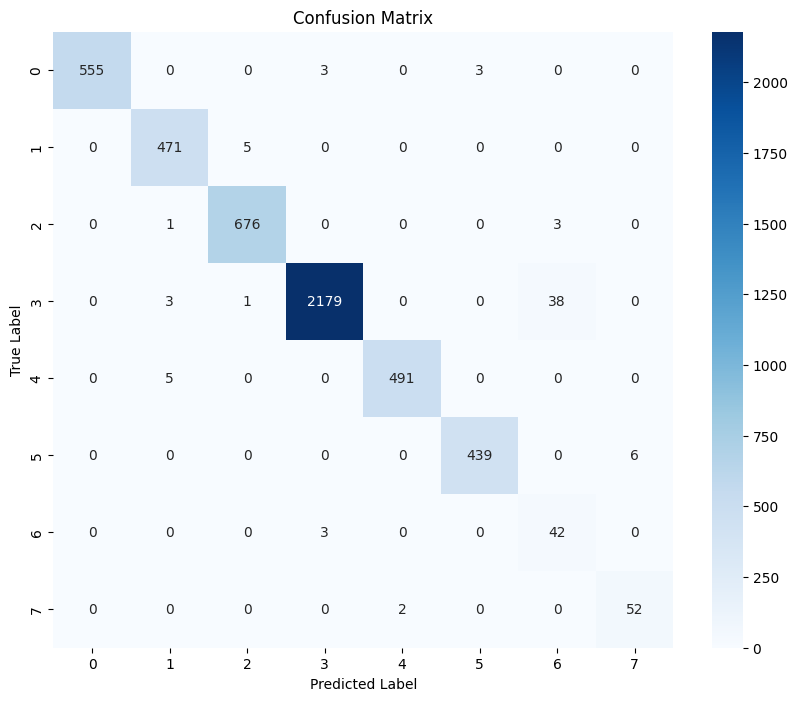

In [32]:
# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(visualization_dir, 'model_tuning_correlation_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


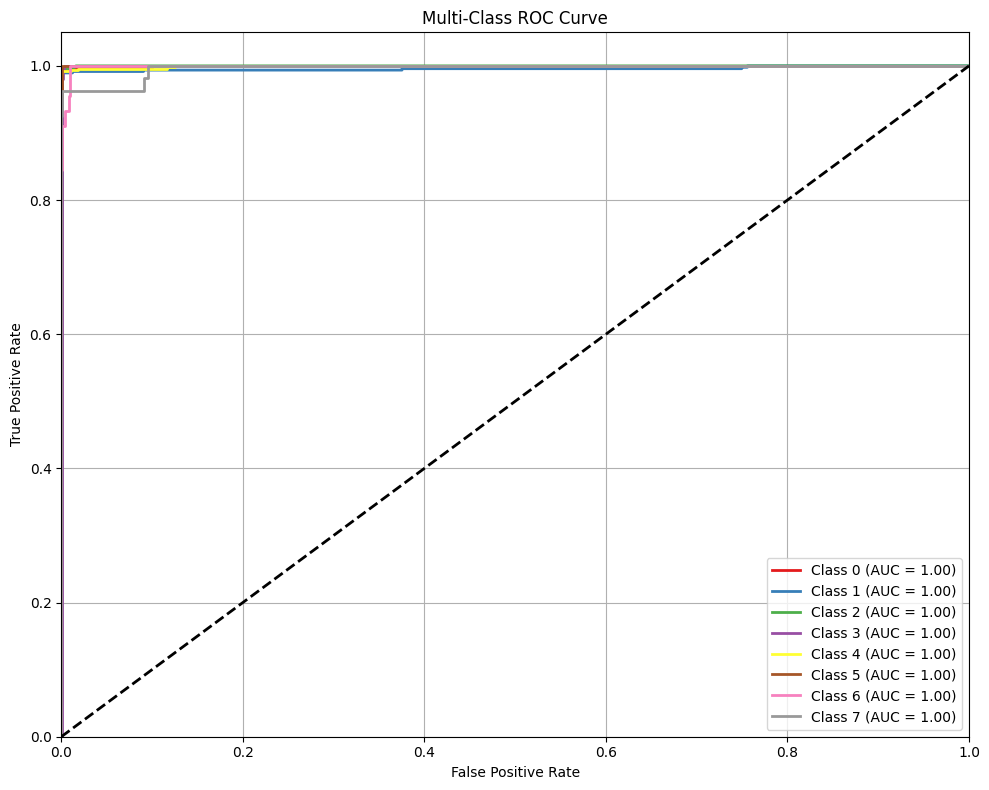

In [33]:
y_pred_proba = best_model_classifier.predict(X_test_seq)

# Binarisasi label (One-Hot Encoding untuk true labels)
n_classes = y_pred_proba.shape[1]
y_true_bin = label_binarize(y_true_labels, classes=range(n_classes))

# ROC Curve per kelas
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve per kelas
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap("Set1", n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})',
             color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(visualization_dir, 'model_tuning_roc_curve.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

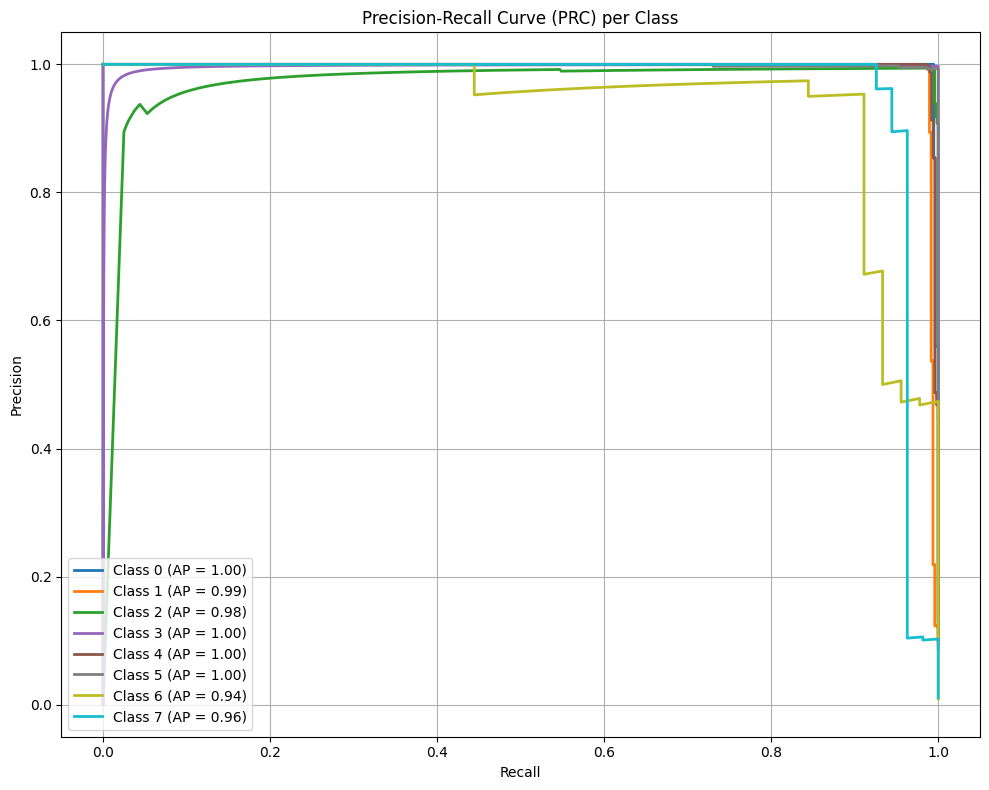

In [34]:
# Hitung Precision-Recall untuk setiap kelas
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_pred_proba[:, i])

# Plot Precision-Recall Curve per kelas
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap("tab10", n_classes)

for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2,
             label=f"Class {i} (AP = {average_precision[i]:.2f})",
             color=colors(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (PRC) per Class")
plt.legend(loc="lower left")
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(visualization_dir, 'model_tuning_pr_curve.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [36]:
# Simpan model dalam format .keras
model_path = os.path.join(artifacts_dir, "Classifier_model_tuning.keras")
best_model_classifier.save(model_path)

In [37]:
best_hps = tuner.get_best_hyperparameters(1)[0]

In [40]:
# Bangun ulang model terbaik
best_model_test = build_model(best_hps)

# Train ulang model
history = best_model_test.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    batch_size=32,
    verbose=1
)

Epoch 1/20
949/949 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - accuracy: 0.6165 - auc: 0.9165 - loss: 0.6681 - precision: 0.6818 - recall: 0.5479 - val_accuracy: 0.8921 - val_auc: 0.9919 - val_loss: 0.2844 - val_precision: 0.8937 - val_recall: 0.8912
Epoch 2/20
949/949 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9023 - auc: 0.9910 - loss: 0.2095 - precision: 0.9106 - recall: 0.8946 - val_accuracy: 0.9386 - val_auc: 0.9954 - val_loss: 0.1692 - val_precision: 0.9393 - val_recall: 0.9386
Epoch 3/20
949/949 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9476 - auc: 0.9954 - loss: 0.1140 - precision: 0.9515 - recall: 0.9432 - val_accuracy: 0.9875 - val_auc: 0.9966 - val_loss: 0.0751 - val_precision: 0.9877 - val_recall: 0.9873
Epoch 4/20
949/949 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9584 - auc: 0.9967 - loss: 0.0909 - precision: 0.9625 - recall: 0.9552 - val_accuracy: 0.9856 - val_auc: 0.9976 - val_loss: 0.0573 - val_precision: 0.9861 - val_recall: 0.9856
Epoch 5/20
949/949 ━━━━━

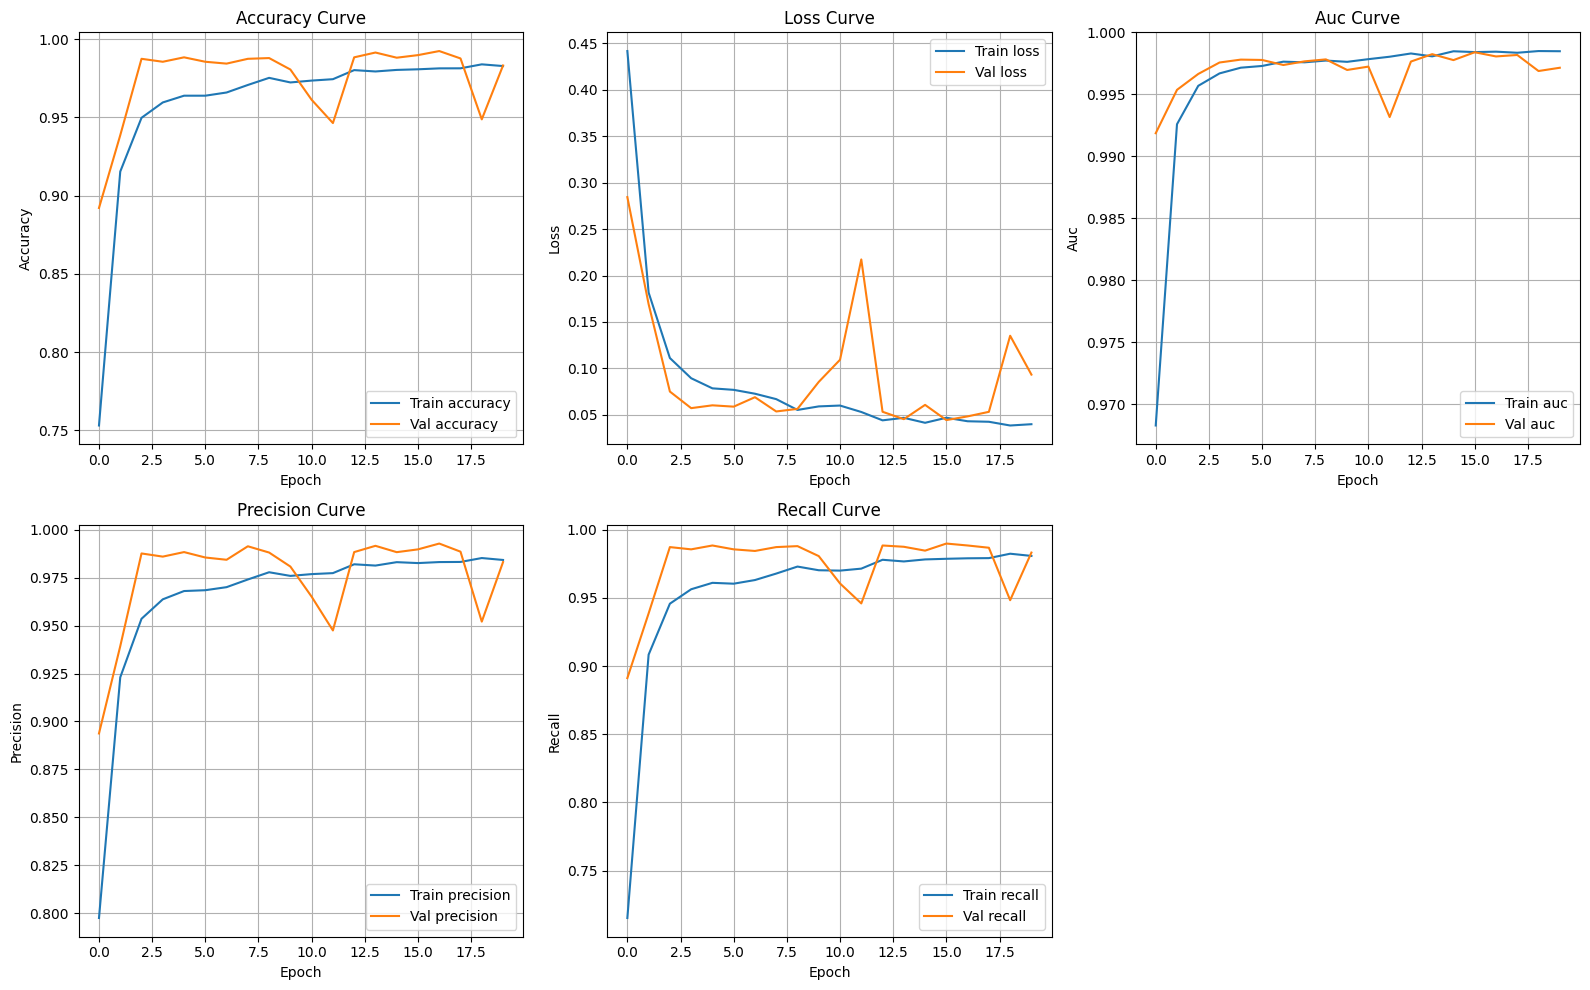

In [41]:
# Plot semua metrik dalam satu plot
metrics_to_plot = ['accuracy', 'loss', 'auc', 'precision', 'recall']
plt.figure(figsize=(16, 10))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 3, i)
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
    plt.title(f'{metric.capitalize()} Curve')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(visualization_dir, 'model_tuning_curve_learning_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

In [42]:
y_pred = best_model_test.predict(X_test_seq)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_seq, axis=1)

print(classification_report(y_true_labels, y_pred_labels))

156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       561
           1       0.98      1.00      0.99       476
           2       1.00      0.99      0.99       680
           3       1.00      0.98      0.99      2221
           4       1.00      0.99      0.99       496
           5       1.00      0.99      0.99       445
           6       0.51      1.00      0.67        45
           7       0.93      0.96      0.95        54

    accuracy                           0.99      4978
   macro avg       0.93      0.99      0.95      4978
weighted avg       0.99      0.99      0.99      4978



In [42]:
# Parameter
sequence_length = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]
n_classes = y_train_seq.shape[1]
lstm_units = 128
attention_heads = 8
attention_units = 64

# Input layer
inputs = Input(shape=(sequence_length, n_features))
inputs = SpatialDropout1D(0.1)(inputs)
# Bidirectional LSTM stack
lstm_out = Bidirectional(
    LSTM(lstm_units, return_sequences=True, dropout=0.1, recurrent_dropout=0.2)
)(inputs)

lstm_out = Bidirectional(
    LSTM(lstm_units // 2, return_sequences=True, dropout=0.1, recurrent_dropout=0.2)
)(lstm_out)

lstm_out = LayerNormalization()(lstm_out) 

# Self-attention mechanism (Multi-head)
attention = MultiHeadAttention(
    num_heads=attention_heads,
    key_dim=attention_units,
    dropout=0.2
)(lstm_out, lstm_out)

# Add & Normalize (residual connection)
attention = Add()([lstm_out, attention])
attention = LayerNormalization()(attention)
attention = Dropout(0.2)(attention)

# Pooling untuk mengubah 3D ke 2D
pooled = GlobalAveragePooling1D()(attention)
pooled = Dropout(0.2)(pooled)

# Fully Connected Layers
dense = Dense(128, activation='relu')(pooled)
dense = BatchNormalization()(dense)
dense = Dropout(0.3)(dense)

dense = Dense(64, activation='relu')(dense)
dense = Dropout(0.3)(dense)

# Output layer
outputs = Dense(n_classes, activation='softmax')(dense)

# Model instantiation
classifier = Model(inputs=inputs, outputs=outputs, name='Classifier')
classifier.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=5e-5, clipnorm=1.0),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

# Summary
classifier.summary()

Model: "Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_1CLONE │ (None, 10, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 10, 256)   │    139,264 │ keras_tensor_1CL… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 10, 128)   │    164,352 │ bidirectional[1]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 128)   │        256 │ bidirectional_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add[1][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 128)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ dropout_1[1][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ dropout_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[1][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_3[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_1[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │        520 │ dropout_4[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 593,736 (2.26 MB)

 Trainable params: 593,480 (2.26 MB)

 Non-trainable params: 256 (1.00 KB)

In [170]:
history = classifier.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/50
911/912 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2664 - auc_37: 0.6689 - loss: 1.3536 - precision_37: 0.3489 - recall_37: 0.1192
Epoch 1: val_loss improved from inf to 0.40929, saving model to checkpoints\best_model.keras
912/912 ━━━━━━━━━━━━━━━━━━━━ 106s 96ms/step - accuracy: 0.2666 - auc_37: 0.6691 - loss: 1.3530 - precision_37: 0.3493 - recall_37: 0.1194 - val_accuracy: 0.9505 - val_auc_37: 0.9964 - val_loss: 0.4093 - val_precision_37: 0.9815 - val_recall_37: 0.8806 - learning_rate: 5.0000e-05
Epoch 2/50
911/912 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6071 - auc_37: 0.9123 - loss: 0.7500 - precision_37: 0.7035 - recall_37: 0.4707
Epoch 2: val_loss improved from 0.40929 to 0.20090, saving model to checkpoints\best_model.keras
912/912 ━━━━━━━━━━━━━━━━━━━━ 87s 96ms/step - accuracy: 0.6072 - auc_37: 0.9124 - loss: 0.7498 - precision_37: 0.7036 - recall_37: 0.4708 - val_accuracy: 0.9734 - val_auc_37: 0.9986 - val_loss: 0.2009 - val_precision_37: 0.9816 - val_rec


MODEL EVALUATION


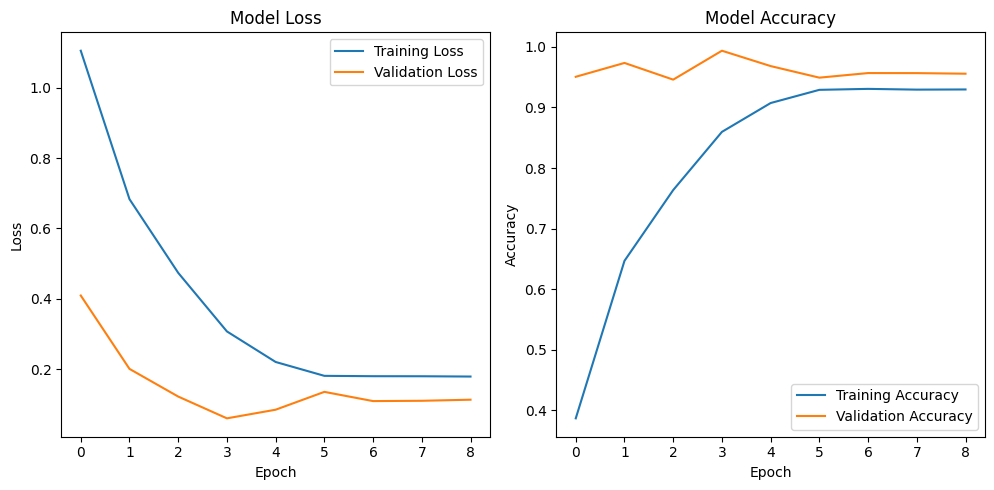

In [180]:
# ================================
# 13. MODEL EVALUATION
# ================================

print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plt.subplot(1, 3, 3)
# plt.plot(history.history['precision'], label='Training Precision')
# plt.plot(history.history['val_precision'], label='Validation Precision')
# plt.title('Model Precision')
# plt.xlabel('Epoch')
# plt.ylabel('Precision')
# plt.legend()
plt.savefig(os.path.join(visualization_dir, 'curve_learning_matrix.png'), dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [172]:
y_pred = classifier.predict(X_test_seq)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_seq, axis=1)

print(classification_report(y_true_labels, y_pred_labels))

326/326 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       996
           1       0.98      0.99      0.99       996
           2       0.99      0.99      0.99      1014
           3       1.00      1.00      1.00      5481
           4       0.99      0.98      0.99      1000
           5       0.99      0.97      0.98       582
           6       0.95      0.95      0.95       105
           7       0.93      0.97      0.95       238

    accuracy                           0.99     10412
   macro avg       0.98      0.98      0.98     10412
weighted avg       0.99      0.99      0.99     10412



In [182]:
# Balanced Accuracy & Kappa Score
print("Balanced Accuracy:", balanced_accuracy_score(y_true_labels, y_pred_labels))
print("Cohen's Kappa Score:", cohen_kappa_score(y_true_labels, y_pred_labels))

Balanced Accuracy: 0.9823772165818052
Cohen's Kappa Score: 0.9905640390420926


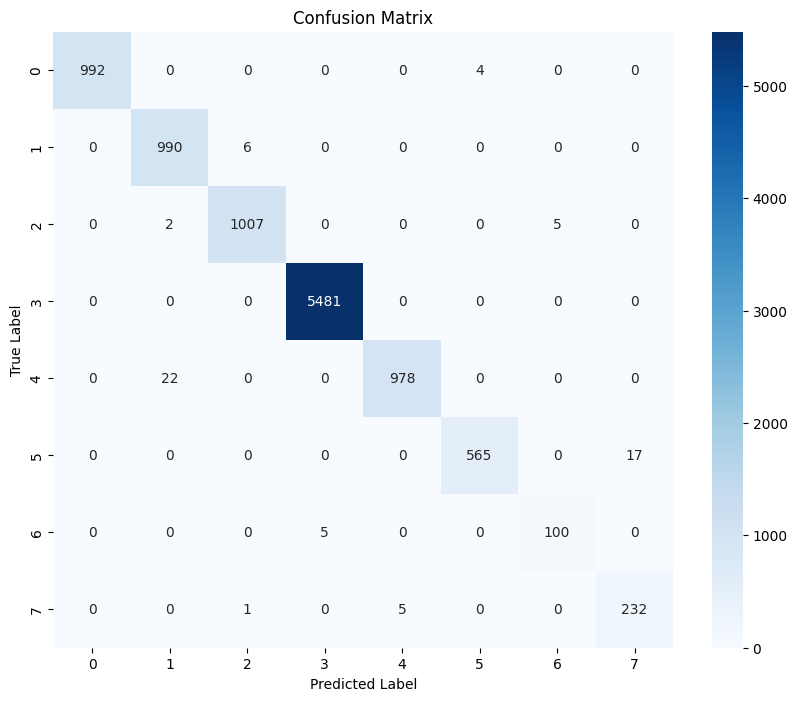

In [181]:
# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(visualization_dir, 'correlation_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step


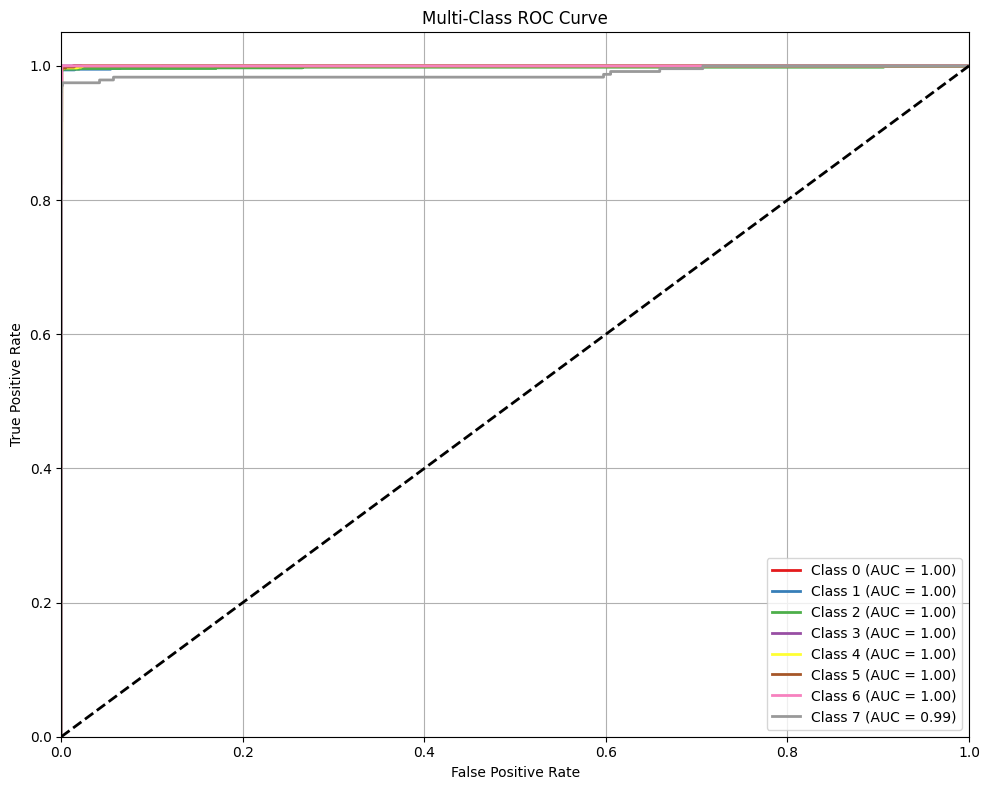

In [188]:
y_pred_proba = classifier.predict(X_test_seq)

# Binarisasi label (One-Hot Encoding untuk true labels)
n_classes = y_pred_proba.shape[1]
y_true_bin = label_binarize(y_true_labels, classes=range(n_classes))

# ROC Curve per kelas
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve per kelas
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap("Set1", n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})',
             color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(visualization_dir, 'roc_curve.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

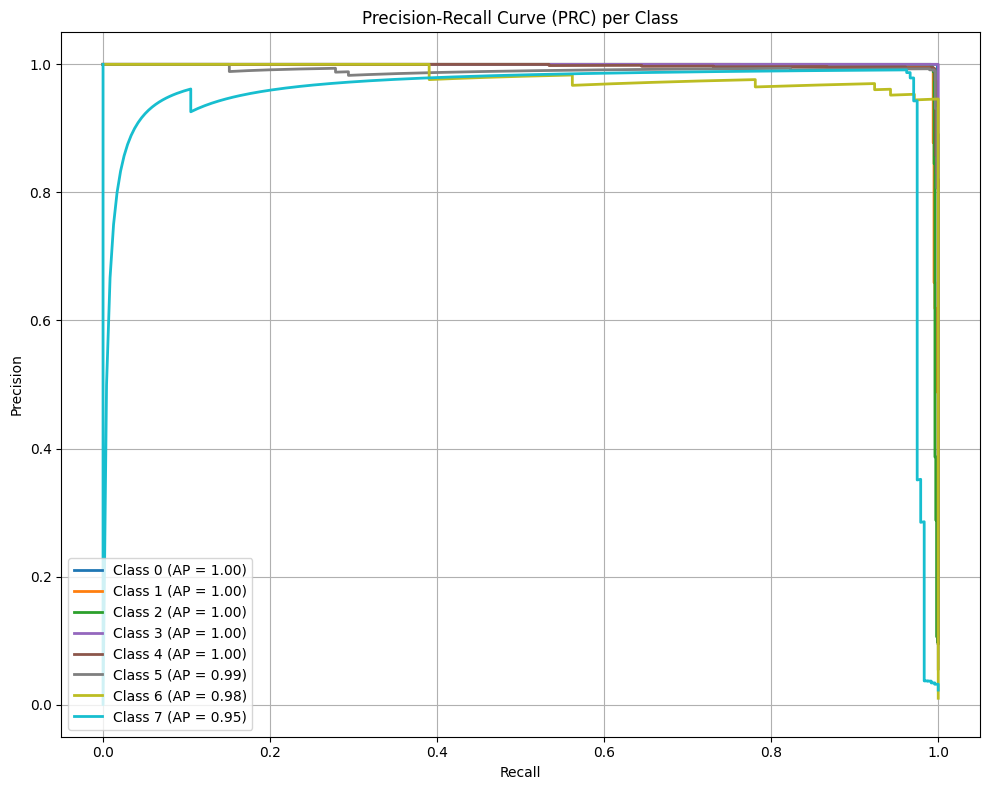

In [195]:
# Hitung Precision-Recall untuk setiap kelas
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_pred_proba[:, i])

# Plot Precision-Recall Curve per kelas
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap("tab10", n_classes)

for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2,
             label=f"Class {i} (AP = {average_precision[i]:.2f})",
             color=colors(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (PRC) per Class")
plt.legend(loc="lower left")
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(visualization_dir, 'pr_curve.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [191]:
# Simpan model dalam format .keras
model_path = os.path.join(artifacts_dir, "Classifier_model.keras")
classifier.save(model_path)

In [ ]:
def build_lstm_autoencoder(hp):
    inputs = Input(shape=(sequence_length, n_features))

    # Encoder LSTM
    encoded = LSTM(
        units=hp.Int('encoder_units', min_value=32, max_value=256, step=32),
        activation='tanh',
        return_sequences=False,
        dropout=hp.Float('encoder_dropout', 0.0, 0.5, step=0.1)
    )(inputs)

    # Latent Space (Dense layer)
    latent = Dense(
        units=hp.Int('latent_dim', min_value=8, max_value=64, step=8),
        activation='relu',
        name='latent_space'
    )(encoded)

    # Repeat for decoder
    repeated = RepeatVector(sequence_length)(latent)

    # Decoder LSTM
    decoded = LSTM(
        units=hp.Int('decoder_units', min_value=32, max_value=256, step=32),
        activation='tanh',
        return_sequences=True,
        dropout=hp.Float('decoder_dropout', 0.0, 0.5, step=0.1)
    )(repeated)

    # Output layer
    outputs = TimeDistributed(Dense(n_features))(decoded)

    # Compile model
    model = Model(inputs, outputs, name='anomaly_detection')
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae']
    )
    return model

In [ ]:
class MultiMetricAutoencoderTuner(RandomSearch):
    def score_trial(self, trial):
        val_loss = trial.metrics.get_last_value("val_loss")
        val_mae = trial.metrics.get_last_value("val_mae")
        val_mse = trial.metrics.get_last_value("val_mse")

        if None in [val_loss, val_mae, val_mse]:
            return float("-inf")

        # Konversi loss menjadi bentuk skor (semakin besar, semakin baik)
        loss_score = 1 / (1 + val_loss)
        mae_score = 1 / (1 + val_mae)
        mse_score = 1 / (1 + val_mse)

        # Gabungkan dengan bobot (sesuaikan bobot sesuai kebutuhanmu)
        score = 0.5 * loss_score + 0.3 * mae_score + 0.2 * mse_score
        return score

In [ ]:
tuner = MultiMetricAutoencoderTuner(
    hypermodel=build_lstm_autoencoder,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=1,
    directory="tuning_multi_metric_ae",
    project_name="autoencoder_latent"
)

tuner.search(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=30,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)